# EECS189 Project T Final Notebook
## Week 2: Testing/Training, Cross-Validation, and Bias-Variance
## This is the solution notebook, so all code will be written out. In the student notebook, specific lines will be left blank for students to fill in
    


In [229]:
#!pip install plotly

In [230]:
# import necessary libraries


# data organization libraries
import numpy as np
import pandas as pd

# data visualization libraries
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# modeling libraries
import sklearn as sk
from sklearn import kernel_ridge

plt.style.use('seaborn')


# Goals

Prediction models that are used in the industry must be able to maintain accuracy on previously unseen data. At this point in your EECS education, you have only learned model assesment within the context of data the model has already seen. This creates a problem, because if we assess our model with the same data that was used to fit it, then we may overestimate how well our model does at prediction. After completing this assigment, students will know the methodology behind improving prediction models so they are ready for use in the real world.

# Context

Suppose that you have been contracted by the Portuguese Government to conduct data driven research on forest fire prevention. The main goal of your research is to create a model that will be used by a government fast forrest fire detection system. Can you predict the area of a fire (and thus its severity) based on certain weather conditions?
    
The data set we are given consists of 517 seperate forrest fire instances from different areas within the Montesinho Natural Park in Portugal, with features being the weather and climate conditions recorded the day of the fire.
    
    

# Forest Fires Data

![](park.png)


In [231]:
#make data set smaller for simple example, then add in other data later.
#start with model with only wind rain area x y


Here is a map of the park that our data set comes from. Lets download a dataset and  take a look at the first couple of rows. We will be loading in a dataset with fewer columns than the one you will use later in this notebook to look at some key ideas.

In [232]:
fire_df = pd.read_csv('raw_df.csv')
fire_df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,area_cat,temp_bins
0,1,2,8,5,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.00,0-5,>25
1,5,4,8,2,95.1,141.3,605.8,17.7,26.4,34,3.6,0.0,16.40,10-50,>25
2,6,5,8,3,92.1,111.2,654.1,9.6,16.6,47,0.9,0.0,2.29,0-5,15-20
3,6,3,8,4,91.6,138.1,621.7,6.3,18.9,41,3.1,0.0,10.34,10-50,15-20
4,4,5,8,0,90.2,99.6,631.2,6.3,21.4,33,3.1,0.0,0.00,0-5,20-25


Oh no! Some of these values are strings and some are numbers! We will be working with regression models in this notebook, so stretch your pandas muscles from last week and replace them with their numerical counterparts

In [233]:
weekdaystr2num = {
    'sun': 0,
    'mon': 1,
    'tue': 2,
    'wed': 3,
    'thu': 4,
    'fri': 5,
    'sat': 6
}

monthstr2num = {
    'jan': 1,
    'feb': 2,
    'mar': 3,
    'apr': 4,
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12
}
areaCatStr2num = {
    '0-5': 1,
    '5-10':2,
    '10-50': 3,
    '50-100': 4
}

tempBinsStr2num = {
    '0-15':1,
    '15-20': 2,
    '20-25': 3,
    '>25': 4,
}

##### START #####
# fire_df['day'] = fire_df['day'].replace(weekdaystr2num)
# fire_df['month'] = fire_df['month'].replace(monthstr2num)
##### END #####

fire_df['area_cat'] = fire_df['area_cat'].replace(areaCatStr2num)
fire_df['temp_bins'] = fire_df['temp_bins'].replace(tempBinsStr2num)

fire_df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,area_cat,temp_bins
0,1,2,8,5,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.00,1,4
1,5,4,8,2,95.1,141.3,605.8,17.7,26.4,34,3.6,0.0,16.40,3,4
2,6,5,8,3,92.1,111.2,654.1,9.6,16.6,47,0.9,0.0,2.29,1,2
3,6,3,8,4,91.6,138.1,621.7,6.3,18.9,41,3.1,0.0,10.34,3,2
4,4,5,8,0,90.2,99.6,631.2,6.3,21.4,33,3.1,0.0,0.00,1,3


- X and Y represent the location of the fire on the simplied map provided above
- month and day are for the date of the fire
- area is the extent of the fire
- wind and rain (and other measures we will introduce later) describe the environmental conditions at the time
    
The response variable, meaning the value we are trying to predict, can be found in the area column, which represents the total area burned per Hectares(ha). The rest of the columns are the weather and climate features we will be using to fit our model. Wind is wind speed in $km/h$ and Rain is outside rain in $mm/m^2$. The other columns represent Codes from the Canadian Fire Weather Index. Below is a diagram outline what each Code means.

![](fwi.png)
    

**Plot** univariate histograms for each of the features in the data frame. The .hist() method of pandas dataframes may be useful.

array([[<AxesSubplot:title={'center':'X'}>,
        <AxesSubplot:title={'center':'Y'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'day'}>],
       [<AxesSubplot:title={'center':'FFMC'}>,
        <AxesSubplot:title={'center':'DMC'}>,
        <AxesSubplot:title={'center':'DC'}>,
        <AxesSubplot:title={'center':'ISI'}>],
       [<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'RH'}>,
        <AxesSubplot:title={'center':'wind'}>,
        <AxesSubplot:title={'center':'rain'}>],
       [<AxesSubplot:title={'center':'area'}>,
        <AxesSubplot:title={'center':'area_cat'}>,
        <AxesSubplot:title={'center':'temp_bins'}>, <AxesSubplot:>]],
      dtype=object)

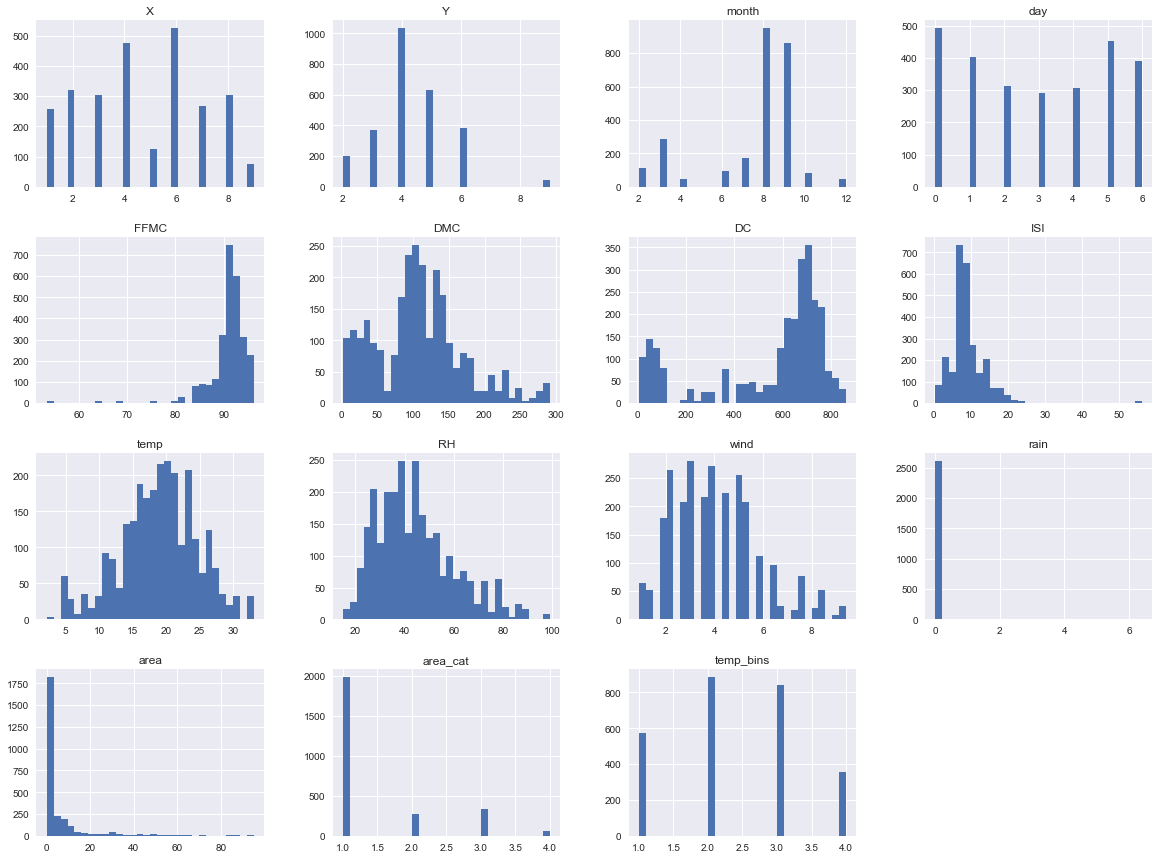

In [234]:
##### START #####
fire_df.hist(bins=30, figsize=(20,15))
##### END #####

**Plot** the following joint distributions. Do you see any possible relationships?

1. X and Y location with area being the size of the dot at that point

Text(0.5, 1.0, 'Fire area by X and Y location')

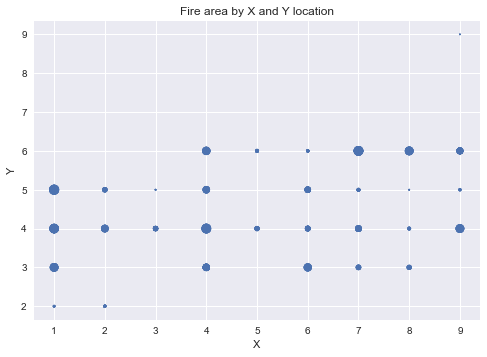

In [235]:
##### START #####
plt.scatter(fire_df["X"], fire_df["Y"], 
            s = fire_df['area'], cmap="viridis")
plt.xlabel('X')
plt.ylabel('Y')
plt.title("Fire area by X and Y location")
##### END #####

2. FFMC and Wind with ISI as the size of the dot

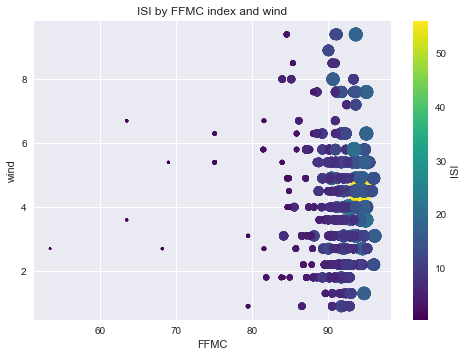

In [236]:
##### START #####
plt.scatter(fire_df["FFMC"], fire_df["wind"], 
            c=fire_df['ISI'], s=fire_df['ISI']*10, cmap="viridis")
plt.xlabel('FFMC')
plt.ylabel('wind')
plt.title("ISI by FFMC index and wind")
plt.colorbar(label="ISI")
##### END #####

3. Some joint distribution of your choice

In [237]:
##### START #####
##### END #####

# Bringing data to Numpy

Pandas is really good for filtering and manipulating large datasets, but when we finally have to train machine learning models, it's best to keep the data in a matrix format. This will make computations run faster and give us access to helpful libraries like sklearn.

Use the df.[to_numpy()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_numpy.html) function in pandas to create the feature and label matrices X and y. Since we're predicting fire area, what column represents a data point's label (what we want to predict)? What columns represent the data point's features?

In [238]:
##### START #####
X = fire_df[[c for c in fire_df.columns if c != 'area']].to_numpy()
y = fire_df[['area']].to_numpy()
##### END #####

## Training Data & Test Data

We only have so much data and we need to decide how much to set aside for testing and how much to use for training. We cannot use the testing data in training because we may overfit to particular details of the limited data set instead of generalizing to the underlying pattern that generated the data.

It would be nice to use as much data as we can to train since we need lots of data to learn the overall pattern. While doing this, we should still have a hefty amount to be used to test since we need to know how well the model is performing.

Let's say we want to do a 7:3 training-test split. Without using sklearn's `train_test_split` function, create matrices `X_train`, `y_train`, `X_test`, and `y_test` to reflect this split. This will help you to understand what this function is doing.

In [239]:
##### START #####
# n_train = int(X.shape[0] * 0.7)
# X_train = X[:n_train]
# y_train = y[:n_train]
# X_test = X[n_train:]
# y_test = y[n_train:]
##### END #####

# add shuffle

# Other method
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Ordinary Least Squares

In this section we will begin to build the linear models we will be evaluating later. We will be using different variants of the OLS and SVM models you have been exposed to previously. Here is a diagram to refresh your knowledge of OLS. For move review material see this note from EE16A linked below.
[OLS_REVIEW_16A](https://eecs16a.org/lecture/Note23.pdf)

    
![](OLS.png)




In [240]:
#this is from data 100 FA2020 lecuture 13
# https://docs.google.com/presentation/d/15olJS1Yuk22spzrNx4It6-eLm8gkZM4pFKKOWhKXBUI/edit#slide=id.g821989616c_1_69
#we should create our own version of these same main points, I'm gonna skip this 
# for now and start using scikit learn methods


## Let's implement!

Now that you have a better understanding of the data and models we will be working with,  we will get some practice with the Scikit-Learn functions that will be used throughout this assigment. We will start with the LinearRegression class from Scikit-Learn's linear_model library. Perhaps use sklearn's
[LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [241]:
def train_linear_regression(X_train, y_train):
    """
    X_train - Training data
    y_train - Training labels
    
    Return reg, an instance of LinearRegression.fit() that represents the trained model
    """
    ##### START #####
    reg = LinearRegression().fit(X_train, y_train)
    ##### END #####
    return reg

# Training and Testing Metrics

How close are the model predictions to the true labels? Let's implement some error metrics with sklearn to see.

Implement 
- Mean Squared Error (MSE) without sklearn functions, and with sklearn functions like [mean_squared_error()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)
- Root Mean Squared Error (RMSE) without sklearn functions, and with sklearn functions

In [242]:
def get_mse_naive(y, y_hat):
    """
    Calculate the MSE with numpy functions
    Do not use any sklearn functions
    
    y - Labels for the data
    y_hat - Predicted label for the data
    
    return MSE
    """
    return np.mean((y - y_hat)**2)

def get_rmse_naive(y, y_hat):
    """
    Calculate the RMSE with numpy functions
    Do not use any sklearn functions
    
    y - Labels for the data
    y_hat - Predicted label for the data
    
    return RMSE
    """
    return np.sqrt(np.mean((y - y_hat)**2))

def get_mse(y, y_hat):
    """
    Calculate the MSE with sklearn functions
    
    y - Labels for the data
    y_hat - Predicted label for the data
    
    Return MSE
    """
    return mean_squared_error(y, y_hat)

def get_rmse(y, y_hat):
    """
    Calculate the RMSE with sklearn and numpy functions
    
    y - Labels for the data
    y_hat - Predicted label for the data
    
    Return RMSE
    """
    return np.sqrt(mean_squared_error(y, y_hat))

Test your implementations with the following code:

In [243]:
y, y_hat = np.array([1, 2, 3]), np.array([2, 0, 3])
assert np.isclose(get_mse_naive(y, y_hat), 1.6666666666666667), "Got {} but expected 1.6666666666666667".format(get_mse_naive(y, y_hat))
assert np.isclose(get_rmse_naive(y, y_hat), 1.2909944487358056), "Got {} but expected 1.2909944487358056".format(get_rmse_naive(y, y_hat))
assert np.isclose(get_mse(y, y_hat), 1.6666666666666667), "Got {} but expected 1.6666666666666667".format(get_mse(y, y_hat))
assert np.isclose(get_rmse(y, y_hat), 1.2909944487358056), "Got {} but expected 1.2909944487358056".format(get_rmse(y, y_hat))
print("Passed")

Passed


# Training Models

Now we want to take the training data we set aside and use it to train models that can correctly identify the underlying pattern. Do not focus too much on the models we use for now; consider it a preview for the rest of this course.

We will be evaluating the training error for each model, but remember that if we focus too much on lowering training data we might run into overfitting.

### Linear Regression

Ok let's put these functions to the test! Report the training error using MSE and RMSE with the LinearRegression model

In [244]:
linear_reg_model = train_linear_regression(X_train, y_train)

##### START How do you get predictions from the model? See sklearn examples for LinearRegression #####
y_hat = linear_reg_model.predict(X_train)
##### END #####

print('Training MSE:', get_mse(y_train, y_hat)) #model might be underfitting
print('Training RMSE:', get_rmse(y_train, y_hat)) #model might be underfitting

y_hat_test = linear_reg_model.predict(X_test)
print()
print('Testing MSE:', get_mse(y_test, y_hat_test)) 
print('Testing RMSE:', get_rmse(y_test, y_hat_test))

Training MSE: 44.877413417717435
Training RMSE: 6.69906063696377

Testing MSE: 55.67818586134104
Testing RMSE: 7.461781681431121


Let's see how we do with other models

### SVR (the regression version of SVM)

Last week, you looked at SVMs, another linear model. sklearn includes an implementation that explicitly does regression for us. It is [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html). 

Complete the training step, which takes into account the parameters C and gamma that are passed into SVR()

Try different hyperparameter values, for C and gamma, to minimize the MSE and RMSE.

In [245]:
def train_SVR(X_train, y_train, gamma=0.2):
    """
    X_train - Training data
    y_train - Training labels
    C - a hyperparameter for SVC, Regularization parameter
    gamma - a hyperparameter for SVC, Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
    
    Return reg, an instance of LinearRegression.fit() that represents the trained model
    """
    
    ##### START #####
    reg = SVR(kernel='rbf', gamma=gamma).fit(X_train, y_train.ravel())
    ##### END #####
    return reg

In [246]:
svr_model = train_SVR(X_train, y_train, gamma=1e3)
# C -> Regularization parameter
# gamma -> Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
# degree, default=3, Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.

##### START How do you get predictions from the model? See sklearn examples for LinearRegression #####
y_hat = svr_model.predict(X_train)
##### END #####

print('Training MSE:', get_mse(y_train, y_hat)) #model might be underfitting
print('Training RMSE:', get_rmse(y_train, y_hat)) #model might be underfitting

y_hat_test = svr_model.predict(X_test)
print()
print('Testing MSE:', get_mse(y_test, y_hat_test)) 
print('Testing RMSE:', get_rmse(y_test, y_hat_test))

Training MSE: 135.11615592054113
Training RMSE: 11.623947518831162

Testing MSE: 175.29349311943267
Testing RMSE: 13.23984490541459


### Kernel Ridge Regression (rbf kernel)
Hm, it seems like svr doesn't do much better than simple linear regression
Let's try adjusting parameters for another model and see where that gets us.

In [247]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.neighbors import KNeighborsRegressor

def train_KernelRidge(X_train, y_train, gamma=0.2):
    """
    X_train - Training data
    y_train - Training labels
    gamma - a hyperparameter for SVC, Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
    
    Return reg, an instance of LinearRegression.fit() that represents the trained model
    """
    ##### START #####
    reg = kernel_ridge.KernelRidge(kernel='rbf', gamma=gamma).fit(X_train, y_train.ravel())
#     reg = kernel_ridge.KernelRidge(kernel='sigmoid', gamma=gamma).fit(X_train, y_train.ravel())


#     reg = RandomForestRegressor(max_depth=10, random_state=0).fit(X_train, y_train.ravel())
#     print(y_train.ravel())
#     reg = HuberRegressor().fit(X_train, y_train.ravel())

#     reg = sk.linear_model.Lasso(alpha=0.1).fit(X_train, y_train.ravel())
#     reg = KNeighborsRegressor(n_neighbors=2).fit(X_train, y_train.ravel())

    ##### END #####
    return reg

In [248]:
kernelRidge_model = train_KernelRidge(X_train, y_train, gamma=2e-2)
# gamma -> Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’

##### START How do you get predictions from the model? See sklearn examples for LinearRegression #####
y_hat = kernelRidge_model.predict(X_train)
##### END #####

print('Training MSE:', get_mse(y_train, y_hat)) #model might be underfitting
print('Training RMSE:', get_rmse(y_train, y_hat)) #model might be underfitting

y_hat_test = kernelRidge_model.predict(X_test)
print()
print('Testing MSE:', get_mse(y_test, y_hat_test)) 
print('Testing RMSE:', get_rmse(y_test, y_hat_test))

Training MSE: 13.990806739095975
Training RMSE: 3.740428683867128

Testing MSE: 20.401182009830308
Testing RMSE: 4.516766765046686


# Tuning the model

Congrats! You have created base models for this fire area prediction problem. Now it is time to tune them to do better on the test set. 

### How do you actually make this model do better?

# K-Fold Cross Validation

An alternative to splitting out data into testing and training sections is k-fold cross validation. This will allow us to use all the data for testing and all the data for testing without mixing the sets at any one time. The only drawback is that we will have to do k times as much computation.

How this works is we split the data into k equal sections, pick one of those sections for validation and the rest of the sections for training. We repeat this k times, each time picking a different section for the validation. After doing this k times, we average the errors and that is our estimation of true error.

Since more data for training and testing helps us, this method should yield more accurate result with the only drawback being that we have to do k times as much computation to get our results.

Now implement k-fold cross validation find a more accurate estimation of the true error of the models we have provided.

-!-
How good are your hyperparameters? How do we measure that? One thought is to estimate error with the test set. But wait! The test set should only be run AFTER we're done training everything or else our final results will be fudged. Here's an idea: let's use our knowledge of k-fold cross validation to split up our training set into a "training set" and a "validation set", and measure accuracy on the validation set. Average the accuracy over all k folds. What is the accuracy of your model?
-!-

Perhaps [sklearn.model_selection.KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) would be useful.

In [249]:
def get_mse_with_k_fold(train_fn, gamma=1e0, gammaPresent=False):
    ##### START #####
    kf = KFold(n_splits=4)
    mses = []
    for train_index, val_index in kf.split(X_train):
        X_train_new, y_train_new = X_train[train_index], y_train[train_index]
        X_val, y_val = X[val_index], y_train[val_index]

        reg = train_fn(X_train_new, y_train_new, gamma=gamma) if gammaPresent else train_fn(X_train_new, y_train_new)

        y_hat = reg.predict(X_val)
        mse = get_mse(y_val, y_hat)
        mses.append(mse)

    mse = np.mean(mses)
    ##### END #####
    return mse
    

In [250]:
print("Linear: Average MSE with K-Fold Cross Validation:", get_mse_with_k_fold(train_linear_regression))
print("SVR: Average MSE with K-Fold Cross Validation:", get_mse_with_k_fold(train_SVR, gamma=1e3, gammaPresent=True))
print("Kernel Ridge: Average MSE with K-Fold Cross Validation:", get_mse_with_k_fold(train_KernelRidge, gamma=2e-2, gammaPresent=True))

Linear: Average MSE with K-Fold Cross Validation: 288.6391578815692
SVR: Average MSE with K-Fold Cross Validation: 186.43330470631577
Kernel Ridge: Average MSE with K-Fold Cross Validation: 265.0246885391237


### The next section will show how the features with low training error correspond to the high test error.
Low training error with high test error indicates that there is overfitting which usually is related to having too much variance in our features. This means the features are fitting noise in the data instead of the underlying pattern that generated the data.

# Measuring the Bias and Variance of Your Model

Is the model doing well?

As noted in lecture, bias is generally expressed as a model's tendency to approximate certain functions even if conflicting features are in the training set, and variance is generally expressed as a model's difference in performance on the test set given a different training set. Also remember the irreducible error is that which cannot be eliminated because it is in our inherently noisy measurements of the labels.

A mathematical formulation is below:

$$\text{Total Noise} = \underbrace{(E[h(x|D)] - f(x))^2}_\text{Bias} + \underbrace{Var(h(x|D))}_\text{Variance} + \underbrace{Var(Z)}_\text{Irreducible Noise}$$

where *h(x|D)* is the model's prediction given a training dataset, *f(x)* is the true label, and *Z* is the inherent noise in the labels. These terms are bias, variance, and irreducible error, respectively. A detailed derivation can be found [here](https://www.eecs189.org/static/notes/n5.pdf) or in the notes.

## The Game Plan - Calculating Bias and Variance

1. Since these values are evaluated over many different training datasets, let's structure this like k-fold cross validation so we can randomly sample datasets. Perhaps, you can use [sklearn.model_selection.KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).
**NOTE:** `X_test` must be the same for all datasets for the bias variance measurement corresponding to the above to be correct.

2. For each of the `k` splits, 
 - train your model using your selected features
 - record predictions for each test datapoint `x`

3. After gathering the above information, average the predicted label over the `k` splits for each input `x` to obtain *E[h(x|D)]* and combine with the appropriate `y` label *f(x)*. Average these values over inputs `x` to get the bias

4. Compute the variance of predictions for each input `x`. Then average over inputs `x` to get the variance *Var(h(x|D))*

### What is the bias of your model? The variance? 

In [251]:
# TODO this  function is COMPLETELY untested

def get_bias_variance(X, y, train_fn, gamma=1e3, gammaPresent=False):
    """
    X- the original training data
    y- the labels for the original training data
    train_fn- the function to train a model
    """
    
    predictions = []
    true_labels = []

    ##### START STEP 1 #####
    n_rest = int(X.shape[0] * 0.75)
    X_rest, X_test = X[:n_rest], X[n_rest:]
    y_rest, y_test = y[:n_rest], y[n_rest:]
    
    kf = sk.model_selection.KFold(n_splits=4)
    for train_index, test_index in kf.split(X_rest):
        X_train, y_train = X[train_index], y[train_index]
    ##### END STEP 1 #####
        ##### START STEP 2 #####
        reg = train_fn(X_train, y_train, gamma=gamma) if gammaPresent else train_fn(X_train, y_train)
        predictions.append(reg.predict(X_test))
        true_labels.append(y_test)
        ##### END STEP 2 #####
    
    ##### START STEP 3 #####
    bias = np.mean((np.mean(predictions, axis=0) - true_labels[0])**2)
    ##### END STEP 3 #####
    
    ##### START STEP 4 #####
    variance = np.std(np.mean(predictions, axis=0))
    ##### END STEP 4 #####
    
    return bias, variance

In [252]:
linearBias, linearVariance = get_bias_variance(X_train, y_train, train_linear_regression)
print("Linear Bias:", linearBias)
print("Linear Variance:", linearVariance)
print()

svrBias, svrVariance = get_bias_variance(X_train, y_train, train_SVR, 1e0, True)
print("SVR Bias:", svrBias)
print("SVR Variance:", svrVariance)
print()

kernelRidgeBias, kernelRidgeVariance = get_bias_variance(X_train, y_train, train_KernelRidge, 1e0, True)
print("Kernel Ridge Bias:", kernelRidgeBias)
print("Kernel Ridge Variance:", kernelRidgeVariance)

Linear Bias: 50.8808504712721
Linear Variance: 10.892156444966732

SVR Bias: 208.93621350461868
SVR Variance: 2.0930936883713045

Kernel Ridge Bias: 271.0283818595872
Kernel Ridge Variance: 8.939093911181336


# Final Model Selection!

Given your insights from above, continue to tune your model until your MSE is less than 20 on the validation set we provide to you. Then report your accuracy on the test set. 